# **ALZHEIMER PREDICTION**
*This machine learning notebook leverages data retrieved from [Kaggle](https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers/data?select=oasis_cross-sectional.csv) to predict the most common age group of individuals who develop Alzheimer's disease based on various attributes from the dataset. The data comes from the Open Access Series of Imaging Studies (OASIS), a project aimed at making MRI datasets of the brain freely available to the scientific community. By compiling and distributing these MRI datasets, the OASIS project facilitates discoveries in basic and clinical neuroscience. The data includes cross-sectional and longitudinal MRI scans from subjects aged 18 to 96, including both nondemented and demented individuals. With a focus on those clinically diagnosed with mild to moderate Alzheimer's disease, this notebook will apply machine learning techniques to identify the most susceptible age groups, utilizing features extracted from the MRI data and other clinical attributes. This analysis aims to contribute to the understanding and early detection of Alzheimer's disease, ultimately supporting efforts in prevention and treatment strategies.*

# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.copy_on_write = True


# Standardization 
from sklearn.preprocessing import StandardScaler

# Data splitting
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Plots
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# **Loading Datasets**

In [2]:
#Cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults
cross_sectional = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv')
cross_sectional.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [3]:
#Longitudinal MRI Data in Nondemented and Demented Older Adults
longitudinal = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv')
longitudinal.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


#  **Data Preparation**

**We begin by removing the unnecessary columns, and renaming the remaining column M/F for clarity in later use.**

In [4]:
longitudinal = longitudinal.drop(columns=['Subject ID', 'MRI ID', 'Hand', 'Visit', 'SES'])
longitudinal = longitudinal.rename(columns={'M/F' : 'Gender'})
longitudinal.describe()

,MR Delay,Age,EDUC,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,595.104558,77.013405,14.597855,27.342318,0.290885,1488.128686,0.729568,1.195461
std,635.485118,7.640957,2.876339,3.683244,0.374557,176.139286,0.037135,0.138092
min,0.000000,60.000000,6.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,0.000000,71.000000,12.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,552.000000,77.000000,15.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,873.000000,82.000000,16.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,2639.000000,98.000000,23.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [5]:
cross_sectional = cross_sectional.drop(columns=['ID', 'Delay', 'Hand','SES'])
cross_sectional = cross_sectional.rename(columns={'M/F' : 'Gender'})
cross_sectional.describe()

,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF
count,436.000000,235.000000,235.00000,235.000000,436.000000,436.000000,436.000000
mean,51.357798,3.178723,27.06383,0.285106,1481.919725,0.791670,1.198894
std,25.269862,1.311510,3.69687,0.383405,158.740866,0.059937,0.128682
min,18.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000
25%,23.000000,2.000000,26.00000,0.000000,1367.750000,0.742750,1.111750
50%,54.000000,3.000000,29.00000,0.000000,1475.500000,0.809000,1.190000
75%,74.000000,4.000000,30.00000,0.500000,1579.250000,0.842000,1.284250
max,96.000000,5.000000,30.00000,2.000000,1992.000000,0.893000,1.563000


**In the following block of code we are cheking if the two datasets are completely equal so that we know whether we should merge them together, since we have data from both cross sectional and longitudinal testings and we want to obtain the data from both of them.**

In [6]:
def check_if_equal(df1, df2):
    if df1.shape != df2.shape:
        return False
    df1_sorted = df1.sort_values(by=df1.columns.tolist()).reset_index(drop=True)
    df2_sorted = df2.sort_values(by=df2.columns.tolist()).reset_index(drop=True)
    return df1_sorted.equals(df2_sorted)

check_if_equal(cross_sectional,longitudinal)

False

**Mergin the datasets (since we do have some distinct columns between both).**

In [7]:
find_difference_when_merge = pd.merge(cross_sectional, longitudinal, indicator=True, how='outer')
differences = find_difference_when_merge[find_difference_when_merge['_merge'] != 'both']
differences_longitudinal = differences[cross_sectional.columns]
final_data = pd.concat([cross_sectional, differences_longitudinal], ignore_index=True)


final_data.describe()

,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF
count,1233.000000,464.000000,829.000000,831.000000,1233.000000,1233.000000,1233.000000
mean,58.861314,3.183190,27.160434,0.287004,1484.379562,0.773534,1.197479
std,24.572535,1.310721,3.707881,0.379123,164.547664,0.061126,0.131880
min,18.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,29.000000,2.000000,26.000000,0.000000,1365.000000,0.723000,1.110000
50%,69.000000,3.000000,29.000000,0.000000,1475.000000,0.770000,1.190000
75%,78.000000,4.000000,30.000000,0.500000,1583.000000,0.832000,1.289000
max,98.000000,5.000000,30.000000,2.000000,2004.000000,0.893000,1.587000


**Next after mergin, it's good practice to check for NA values in the final data so that we don't encounter problems such as Biased model, reduced efficiency of the general data, incorrect distribution in our data when doing visualization etc..**

In [8]:
final_data.isna().sum()

Gender      0
Age         0
Educ      769
MMSE      404
CDR       402
eTIV        0
nWBV        0
ASF         0
dtype: int64

**As we can see we do have NA values in the Education, MMSE and CDR columns, so we should remove them.**

In [9]:
final_data = final_data.dropna(subset=['Educ', 'MMSE', 'CDR'])
final_data.isna().sum()

Gender    0
Age       0
Educ      0
MMSE      0
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

**Now, that we got rid of the NA values. We can proceed with data analysis, beginning with indexing the data which helps with efficiency in the retrieval of the data, it optimizes the query performance, it gives better scalability etc..**

# **Index the data**

In [10]:
final_data['ID'] = final_data.index
final_data

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
0,F,74,2.0,29.0,0.0,1344,0.743,1.306,0
1,F,55,4.0,29.0,0.0,1147,0.810,1.531,1
2,F,73,4.0,27.0,0.5,1454,0.708,1.207,2
8,M,74,5.0,30.0,0.0,1636,0.689,1.073,8
9,F,52,3.0,30.0,0.0,1321,0.827,1.329,9
...,...,...,...,...,...,...,...,...,...
1219,M,88,1.0,26.0,1.0,1419,0.674,1.236,1219
1223,M,89,4.0,28.0,0.0,1631,0.682,1.076,1223
1226,M,90,2.0,21.0,0.5,1307,0.689,1.342,1226
1227,M,90,1.0,23.0,0.5,1668,0.644,1.052,1227


# **Data Analysis**

**We begin with a box plot to get general sense of the distribution of our data that we work with. And from there decide what and how much to refine (outliers detection).**

Age        Axes(0.125,0.712609;0.227941x0.167391)
Educ    Axes(0.398529,0.712609;0.227941x0.167391)
MMSE    Axes(0.672059,0.712609;0.227941x0.167391)
CDR        Axes(0.125,0.511739;0.227941x0.167391)
eTIV    Axes(0.398529,0.511739;0.227941x0.167391)
nWBV    Axes(0.672059,0.511739;0.227941x0.167391)
ASF         Axes(0.125,0.31087;0.227941x0.167391)
ID       Axes(0.398529,0.31087;0.227941x0.167391)
dtype: object

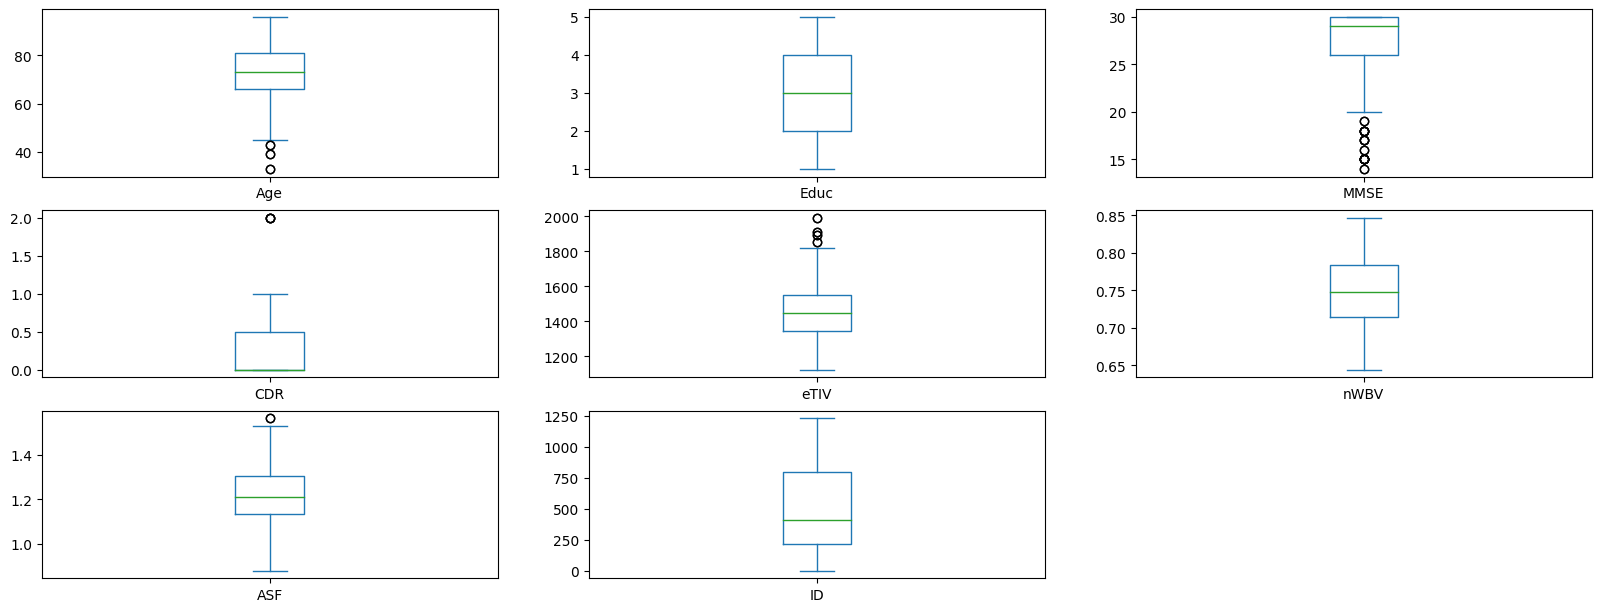

In [11]:
final_data.plot(kind='box', subplots=True, layout=(4,3), sharex=False, figsize=(20, 10))

**From the box plot itself we can see that we do have a presence of outliers in fer columns, but let's visualize the data with some more graphs before moving to deal with the outliers.**

**To get even better sense of the distribution, we will use Histogram**.

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Educ'}>,
        <Axes: title={'center': 'MMSE'}>],
       [<Axes: title={'center': 'CDR'}>,
        <Axes: title={'center': 'eTIV'}>,
        <Axes: title={'center': 'nWBV'}>],
       [<Axes: title={'center': 'ASF'}>, <Axes: title={'center': 'ID'}>,
        <Axes: >]], dtype=object)

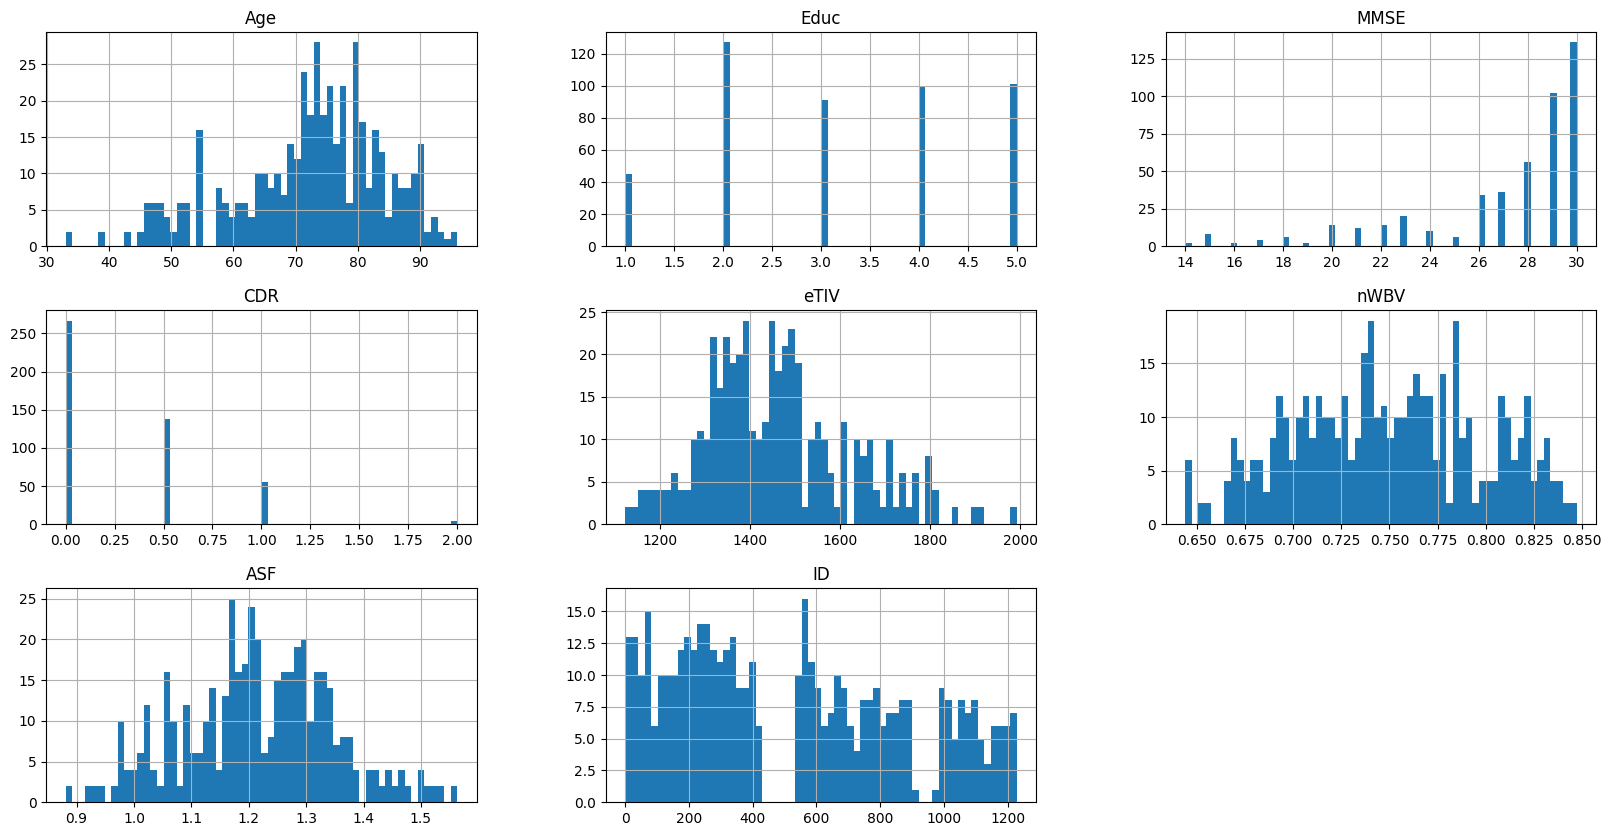

In [12]:
final_data.hist(bins=60, figsize=(20, 10))

**The skewness for some of the histograms (on the x axis) indicates that there's presence of at least one (or more) rows from our data that have those values. From this we can try and understand that this might represent a potential outlier indicator. From both the Histogram and the Box plot we can see that we have potential outliers in the columns (Age, CDR, eTIV, MMSE, ASF). Therefore, we will try to refine the data by removing the potential outliers. we will start with "Age" column. As we can see for the age < 50 we start to have a lot less samples compared to > 50 (It's maybe even better to consider it as < 60, but let's see where we get with this first, and then I will refine further if needed). Let's determine which samples have age < 50. And I will further use scatter plots to really make it easier and spot the stand outs from our data.**

In [13]:
final_data[final_data['Age']<50]

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
16,M,39,3.0,28.0,0.0,1636,0.813,1.073,16
18,F,48,5.0,29.0,0.0,1326,0.785,1.323,18
40,F,47,4.0,30.0,0.0,1346,0.829,1.304,40
53,F,46,5.0,30.0,0.0,1585,0.817,1.107,53
64,M,33,4.0,30.0,0.0,1709,0.784,1.027,64
66,F,49,5.0,30.0,0.0,1459,0.808,1.203,66
69,M,43,4.0,30.0,0.0,1547,0.847,1.134,69
81,F,47,4.0,30.0,0.0,1311,0.835,1.339,81
89,F,47,5.0,29.0,0.0,1357,0.809,1.294,89
166,F,49,4.0,30.0,0.0,1316,0.820,1.334,166


<Axes: xlabel='ID', ylabel='Age'>

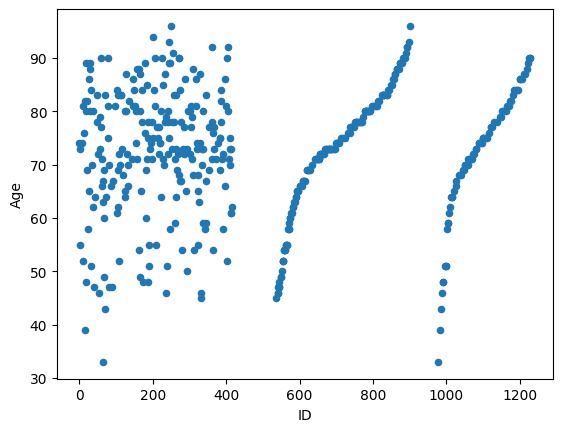

In [14]:
final_data[['ID','Age']].plot(kind='scatter', x='ID', y='Age')

**I will remove all the data which is < 50, due to the obvious potential for outliers for samples that have age < 50**.

In [15]:
final_data[final_data['Age']<=40.00]

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
16,M,39,3.0,28.0,0.0,1636,0.813,1.073,16
64,M,33,4.0,30.0,0.0,1709,0.784,1.027,64
977,M,33,4.0,30.0,0.0,1709,0.784,1.027,977
984,M,39,3.0,28.0,0.0,1636,0.813,1.073,984


In [16]:
final_data = final_data[final_data['Age']>40.00]

**We can proceed with MMSE column, based on the Histogram we will check which samples fall under the separation of < 26.**

In [17]:
final_data[final_data['MMSE']>=20.0]

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
0,F,74,2.0,29.0,0.0,1344,0.743,1.306,0
1,F,55,4.0,29.0,0.0,1147,0.810,1.531,1
2,F,73,4.0,27.0,0.5,1454,0.708,1.207,2
8,M,74,5.0,30.0,0.0,1636,0.689,1.073,8
9,F,52,3.0,30.0,0.0,1321,0.827,1.329,9
...,...,...,...,...,...,...,...,...,...
1219,M,88,1.0,26.0,1.0,1419,0.674,1.236,1219
1223,M,89,4.0,28.0,0.0,1631,0.682,1.076,1223
1226,M,90,2.0,21.0,0.5,1307,0.689,1.342,1226
1227,M,90,1.0,23.0,0.5,1668,0.644,1.052,1227


<Axes: xlabel='ID', ylabel='MMSE'>

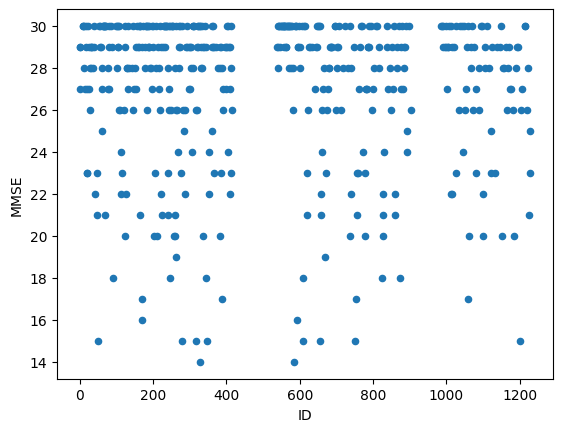

In [18]:
final_data[['ID','MMSE']].plot(kind='scatter', x='ID', y='MMSE')

In [19]:
final_data = final_data[final_data['MMSE']>=20.00]

**We proceed for CDR, for the samples > 1.**

In [20]:
final_data[final_data['CDR']<=1.0]

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
0,F,74,2.0,29.0,0.0,1344,0.743,1.306,0
1,F,55,4.0,29.0,0.0,1147,0.810,1.531,1
2,F,73,4.0,27.0,0.5,1454,0.708,1.207,2
8,M,74,5.0,30.0,0.0,1636,0.689,1.073,8
9,F,52,3.0,30.0,0.0,1321,0.827,1.329,9
...,...,...,...,...,...,...,...,...,...
1219,M,88,1.0,26.0,1.0,1419,0.674,1.236,1219
1223,M,89,4.0,28.0,0.0,1631,0.682,1.076,1223
1226,M,90,2.0,21.0,0.5,1307,0.689,1.342,1226
1227,M,90,1.0,23.0,0.5,1668,0.644,1.052,1227


<Axes: xlabel='ID', ylabel='CDR'>

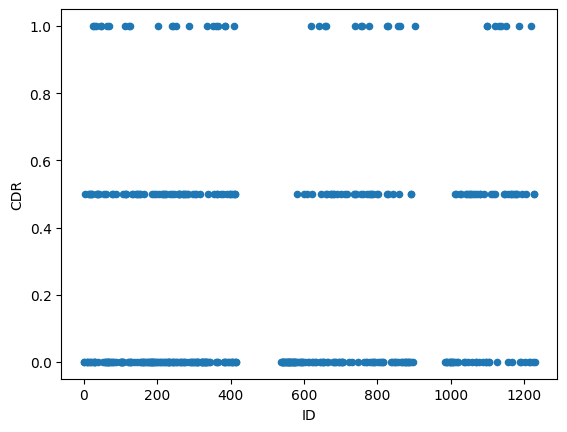

In [21]:
final_data[['ID','CDR']].plot(kind='scatter', x='ID', y='CDR')

In [22]:
final_data = final_data[final_data['CDR']<=1.0]

**Then for eTIV with anything > 1800.**

In [23]:
final_data[final_data['eTIV']<=1800.0]

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
0,F,74,2.0,29.0,0.0,1344,0.743,1.306,0
1,F,55,4.0,29.0,0.0,1147,0.810,1.531,1
2,F,73,4.0,27.0,0.5,1454,0.708,1.207,2
8,M,74,5.0,30.0,0.0,1636,0.689,1.073,8
9,F,52,3.0,30.0,0.0,1321,0.827,1.329,9
...,...,...,...,...,...,...,...,...,...
1219,M,88,1.0,26.0,1.0,1419,0.674,1.236,1219
1223,M,89,4.0,28.0,0.0,1631,0.682,1.076,1223
1226,M,90,2.0,21.0,0.5,1307,0.689,1.342,1226
1227,M,90,1.0,23.0,0.5,1668,0.644,1.052,1227


<Axes: xlabel='ID', ylabel='eTIV'>

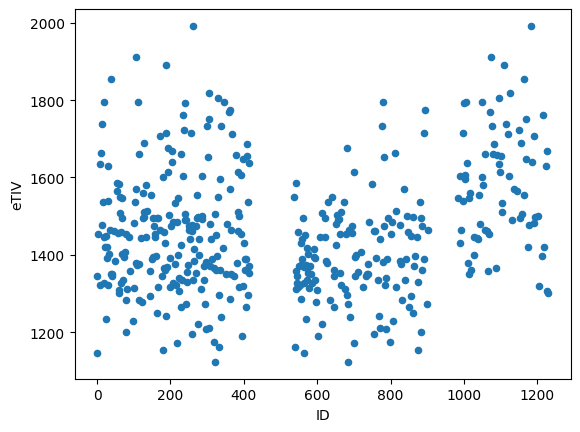

In [24]:
final_data[['ID','eTIV']].plot(kind='scatter', x='ID', y='eTIV')

In [25]:
final_data = final_data[final_data['eTIV']<=1800.00]

**ASF, with anythiing > 1.5.**

In [26]:
final_data[final_data['ASF']<=1.5]

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
0,F,74,2.0,29.0,0.0,1344,0.743,1.306,0
2,F,73,4.0,27.0,0.5,1454,0.708,1.207,2
8,M,74,5.0,30.0,0.0,1636,0.689,1.073,8
9,F,52,3.0,30.0,0.0,1321,0.827,1.329,9
11,F,81,5.0,30.0,0.0,1664,0.679,1.055,11
...,...,...,...,...,...,...,...,...,...
1219,M,88,1.0,26.0,1.0,1419,0.674,1.236,1219
1223,M,89,4.0,28.0,0.0,1631,0.682,1.076,1223
1226,M,90,2.0,21.0,0.5,1307,0.689,1.342,1226
1227,M,90,1.0,23.0,0.5,1668,0.644,1.052,1227


<Axes: xlabel='ID', ylabel='ASF'>

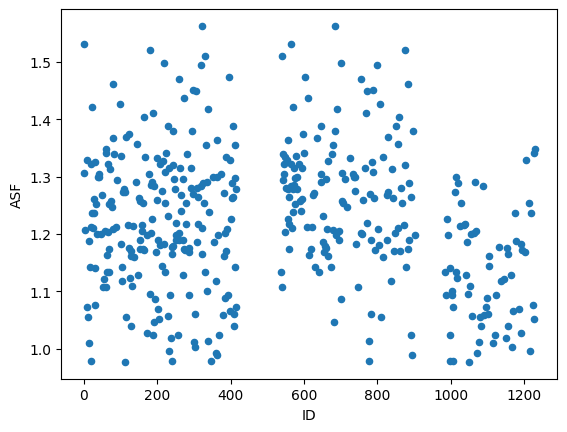

In [27]:
final_data[['ID','ASF']].plot(kind='scatter', x='ID', y='ASF')

In [28]:
final_data = final_data[final_data['ASF']<=1.5]

**Education with < 2.**

In [29]:
final_data[final_data['Educ']<=2.00]

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
0,F,74,2.0,29.0,0.0,1344,0.743,1.306,0
13,M,76,2.0,28.0,0.5,1738,0.719,1.010,13
14,M,82,2.0,27.0,0.5,1477,0.739,1.188,14
20,F,69,2.0,23.0,0.5,1447,0.757,1.213,20
21,M,82,2.0,27.0,0.5,1420,0.710,1.236,21
...,...,...,...,...,...,...,...,...,...
1215,M,87,2.0,30.0,0.0,1762,0.719,0.996,1215
1219,M,88,1.0,26.0,1.0,1419,0.674,1.236,1219
1226,M,90,2.0,21.0,0.5,1307,0.689,1.342,1226
1227,M,90,1.0,23.0,0.5,1668,0.644,1.052,1227


In [30]:
final_data = final_data[final_data['Educ']>2.00]

**Now, we should again do a boxplot in order to see whether we actually refined the data and get a feeling if we need to further refine.**

Age        Axes(0.125,0.712609;0.227941x0.167391)
Educ    Axes(0.398529,0.712609;0.227941x0.167391)
MMSE    Axes(0.672059,0.712609;0.227941x0.167391)
CDR        Axes(0.125,0.511739;0.227941x0.167391)
eTIV    Axes(0.398529,0.511739;0.227941x0.167391)
nWBV    Axes(0.672059,0.511739;0.227941x0.167391)
ASF         Axes(0.125,0.31087;0.227941x0.167391)
ID       Axes(0.398529,0.31087;0.227941x0.167391)
dtype: object

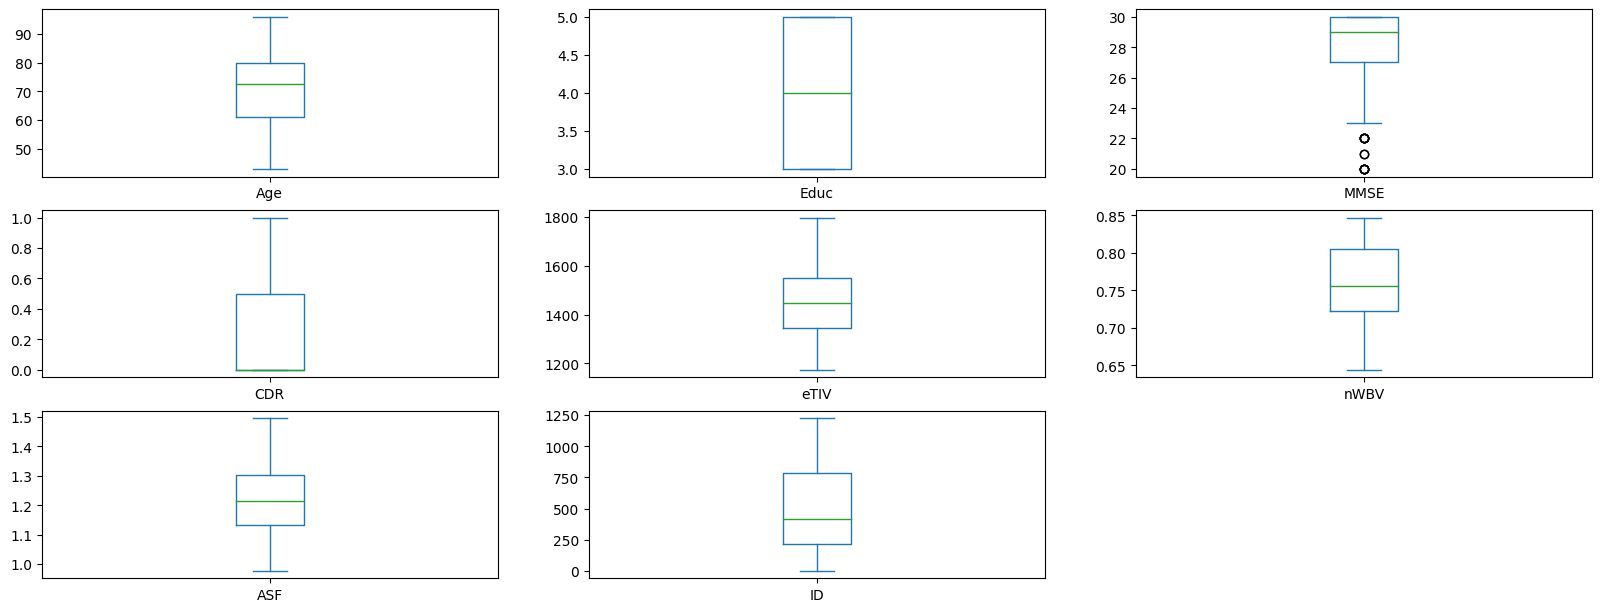

In [31]:
final_data.plot(kind='box', subplots=True, layout=(4,3), sharex=False, figsize=(20, 10))

**As we can see we do have a significant improvement over all of our columns, except for the MMSE. For the MMSE the leftover outliers are not removed, because on the previous box-plot representation of all features, they most probably weren't outliers (our assumption for this column is not correct). More specifically on a global scale they're not clasified as outliers, since they stayed the same after refining.**

**Again, doing histogram representation on the refined data.**

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Educ'}>,
        <Axes: title={'center': 'MMSE'}>],
       [<Axes: title={'center': 'CDR'}>,
        <Axes: title={'center': 'eTIV'}>,
        <Axes: title={'center': 'nWBV'}>],
       [<Axes: title={'center': 'ASF'}>, <Axes: title={'center': 'ID'}>,
        <Axes: >]], dtype=object)

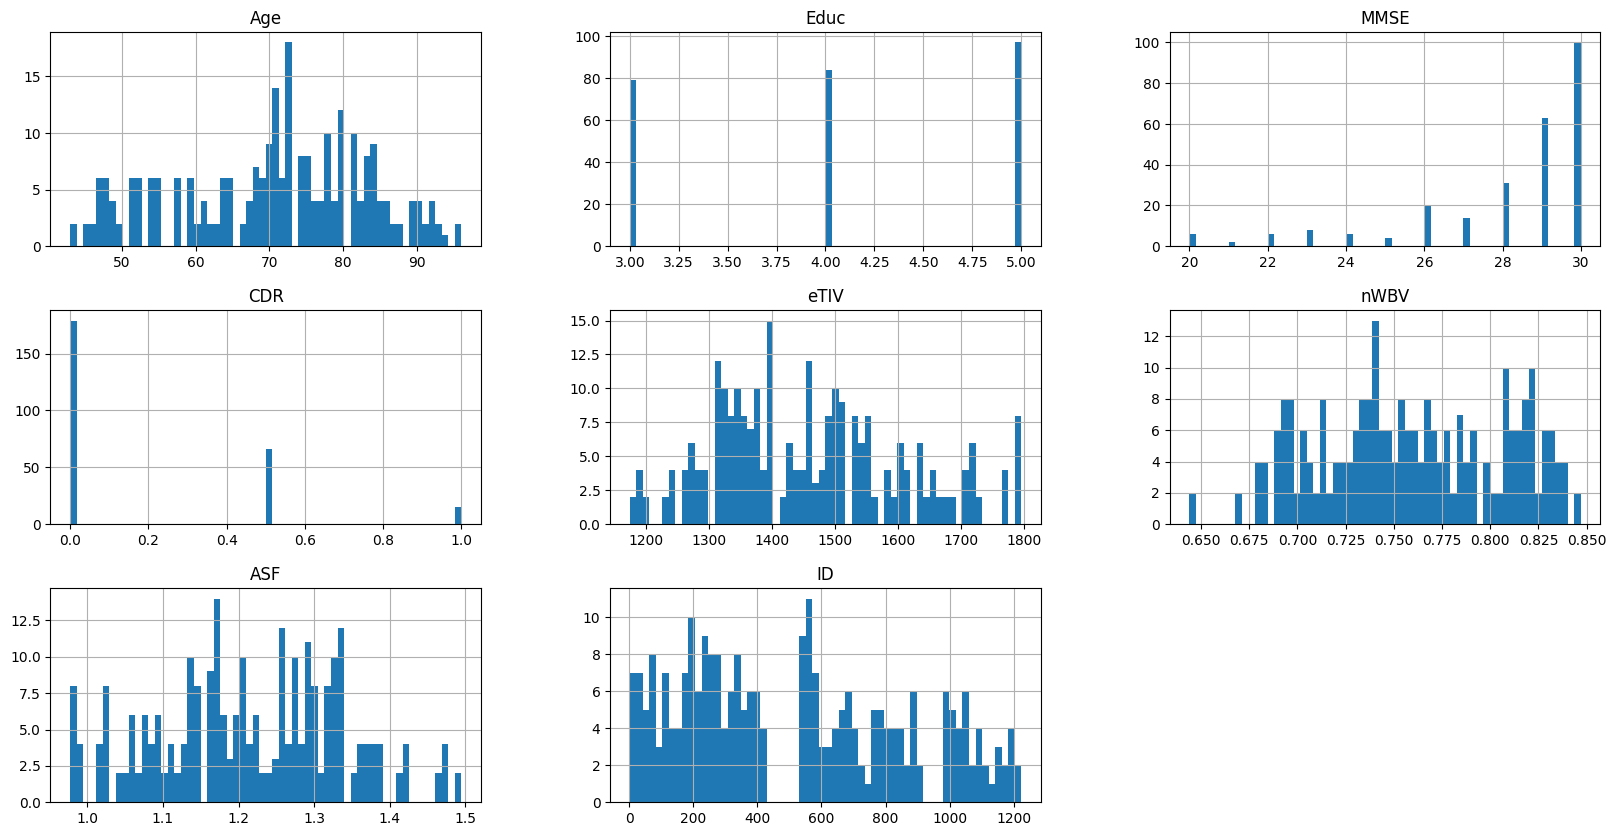

In [32]:
final_data.hist(bins=60, figsize=(20, 10))

**Now that we are done with our data analysis and refinement, we can proceed with splitting the data in order to train the model.**

# **Data Splitting**

In [33]:
final_data=final_data[final_data["Age"]!=94]
final_data.drop(columns=['Gender'],inplace = True)  
X = final_data.drop(columns=['ID', 'Age'])  
y = final_data['Age']
feature_names = X.columns
scaler=StandardScaler()
X= scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=np.random)

**The initial idea of the split is to filter out rows where the "Age" column is 94 because it's too far out number that was only causing problems and there are not many people at that age to be considered to begin with so we dropped it. Drop the "Gender" column from the dataset because we want to determine based on age in general and not on age in Males or Females. Standard scaling is applied to the features (X) to normalize their values. Finally, the dataset is split into training and testing sets (X_train, X_test, y_train, y_test) using a 80-20 split ratio, ensuring reproducibility with a specified random seed (random_state=np.random).**

**Once the data is splitted, we begin with using Decision Tree Clasifier algorithm for our training of the model. Decision Tree Classifier is a supervised learning algorithm used for classification tasks. It partitions the feature space into segments, where each node represents a decision based on feature values, leading to a tree-like structure. It's interpretable, handles both numerical and categorical data, and is prone to overfitting without regularization techniques like pruning. Decision trees are foundational in ensemble methods like Random Forests and Gradient Boosting, enhancing predictive accuracy and robustness.**

# **Decision Tree Clasifier**

In [34]:
dtc = DecisionTreeClassifier()

iters=100
avg_tts_dtc=0
avg_cv_dtc=0
for i in range(iters):
    dtc.fit(X_train,y_train)
    sc=dtc.score(X_test,y_test)
    cv_sc=cross_val_score(dtc, X, y,cv=2)
    avg_tts_dtc+=sc
    avg_cv_dtc+=cv_sc[1]
    #print(sc)
print("Train test split accuracy of the model: " + str(avg_tts_dtc / iters))
print("Cross validation accuracy of the model: " + str(avg_cv_dtc / iters))

Train test split accuracy of the model: 0.769230769230769
Cross validation accuracy of the model: 0.9922480620155053


**In evaluating the model's performance, we consider both the Train Test Split and Cross Validation results. A good model typically achieves a high accuracy on the test set (usually above 70% to 80%), indicating effective generalization to new data. Cross validation accuracy provides a more robust estimate, often surpassing 80% to 90%, highlighting the model's consistency across different data subsets. Overall in both Train Test Split and Cross Validation the numbers that we get as accuracy meet the standard for good model.**

<function matplotlib.pyplot.show(close=None, block=None)>

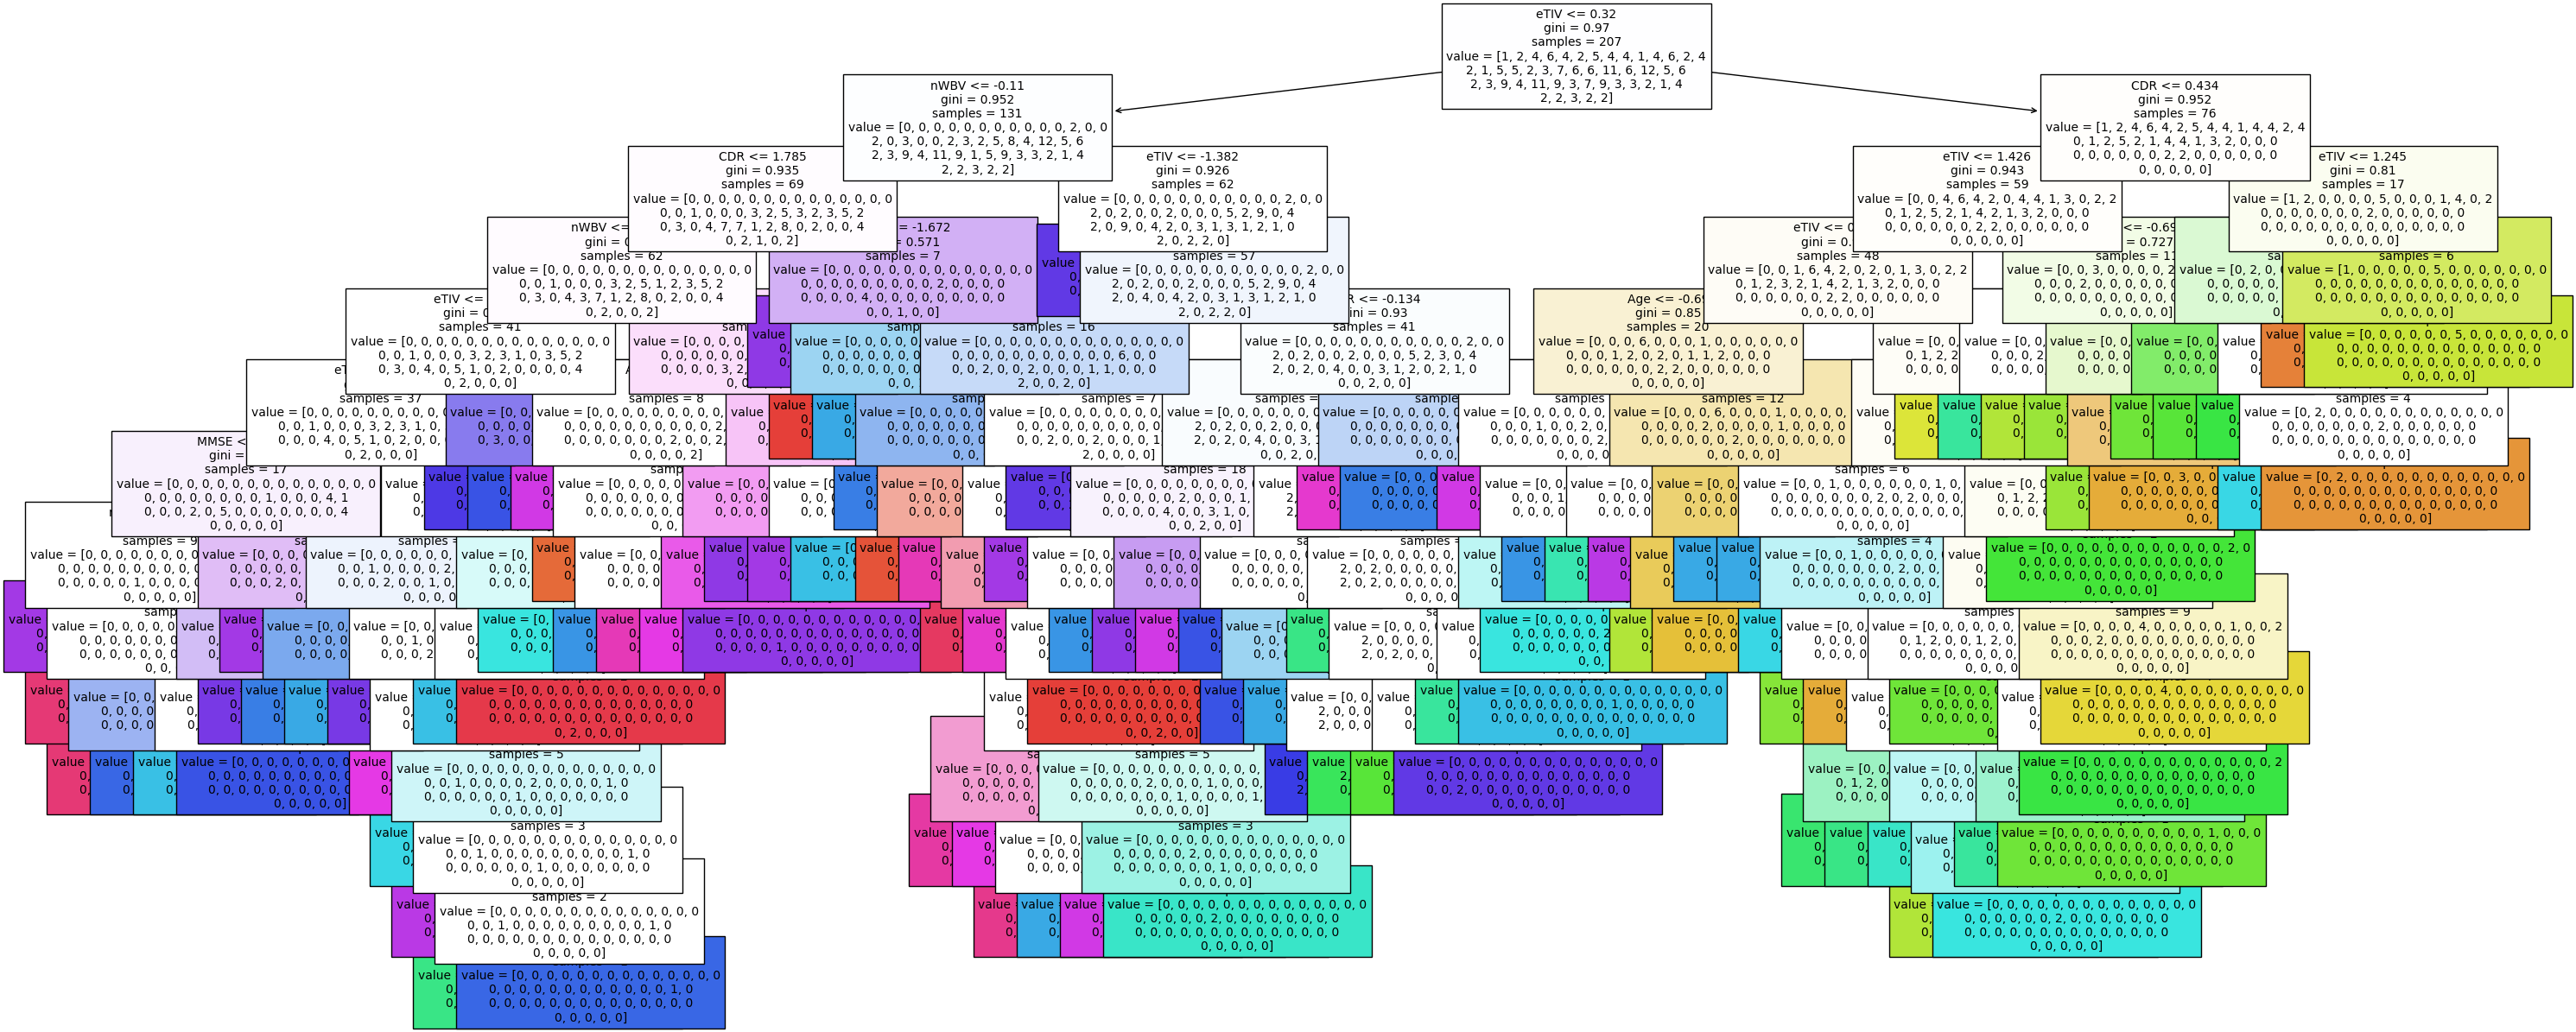

In [35]:
plt.figure("Decision Tree Classifier", figsize=[35,15])
plot_tree(dtc, filled=True, feature_names=final_data.columns, fontsize=10)
plt.show

**Another important data that might be useful to us is to see which feature is actually most impactful to the prediction of the age group for developing an Alzheimer. As we can see down in the graph, the biggest factor is the "nWBV (Normalized Whole Brain Volume)", and this is for a reason. (nWBV) is a critical feature in Alzheimer's disease prediction and diagnosis because it quantifies brain atrophy, a hallmark of Alzheimer's. Alzheimer's disease is characterized by the progressive loss of neurons and synapses, leading to a reduction in brain volume. Specifically, the shrinkage of the hippocampus and other brain regions associated with memory and cognitive functions is prevalent in Alzheimer's patients. By normalizing brain volume to account for individual differences in head size, nWBV provides a standardized measure to detect these changes, allowing for more accurate tracking of disease progression.**

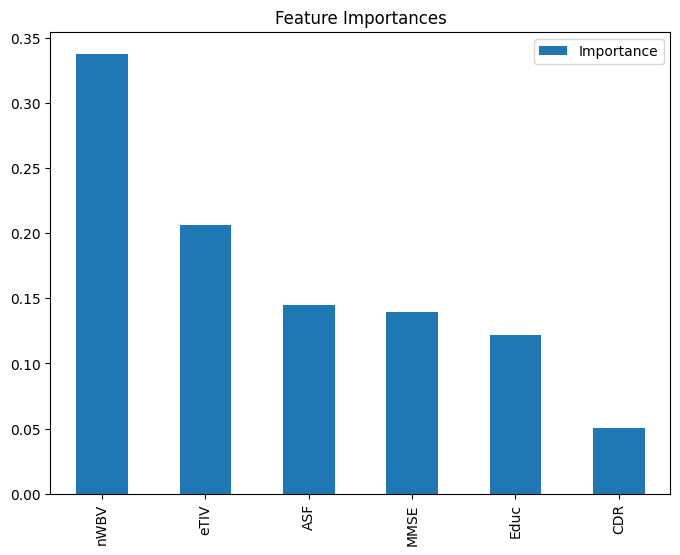

In [36]:
# Feature importance
feat_importances = pd.DataFrame(dtc.feature_importances_, index=feature_names, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting the feature importances
feat_importances.plot(kind='bar', figsize=(8, 6))
plt.title('Feature Importances')
plt.show()

# **Logistic Regression**

**Logistic Regression is a supervised learning algorithm used for binary classification tasks. It models the probability of the default class (usually labeled as 1) using the logistic function, which maps any real-valued input to a probability value between 0 and 1. Logistic Regression assumes a linear relationship between the independent variables (features) and the log-odds of the dependent variable. It is widely used due to its simplicity, interpretability, and efficiency in handling large datasets. However, it performs best when the decision boundary between classes is linear or when features are not highly correlated.**

In [37]:
lr = LogisticRegression()

iters=100
avg_tts_lr=0
avg_cv_lr=0
for i in range(iters):
    lr.fit(X_train,y_train)
    sc=lr.score(X_test,y_test)
    cv_sc=cross_val_score(lr, X, y,cv=2)
    avg_tts_lr+=sc
    avg_cv_lr+=cv_sc[1]
    #print(sc)
print("Train test split accuracy of the model: " + str(avg_tts_lr / iters))
print("Cross validation accuracy of the model: " + str(avg_cv_lr / iters))

Train test split accuracy of the model: 0.13461538461538491
Cross validation accuracy of the model: 0.2713178294573639


**The Logistic Regressor's performance is evaluated based on both Train Test Split and Cross Validation results. The model achieved a low accuracy of approximately 13% (in most of the cases, but it may differ) on the test set, indicating poor generalization to unseen data. Cross validation provided a slightly higher accuracy of around 27% (again in most of the cases), suggesting modest improvement but still indicating limitations in predictive capability across different data subsets. These results suggest the model may not effectively capture the underlying patterns in the data. Further optimization, such as parameter tuning or considering alternative algorithms, may be necessary to enhance its performance and suitability for the task. Or this algorithm is not the right choice when it comes to a problem like this. Just for reference a good results would be considered for anything >= 70% which is actually way off in our case.**

# **Random Forest Classifier**

**Random Forest Classifier is an ensemble learning method used for classification tasks. It operates by constructing multiple decision trees during training and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Each tree in the forest is built from a subset of the training data and features, making it less susceptible to overfitting compared to individual decision trees. Random forests can handle both numerical and categorical data, and they are robust against noise and missing values. They are widely used due to their high accuracy, scalability, and ability to capture complex relationships in data. However, they may be slower to train and predict compared to simpler models like logistic regression. Random Forests also provide feature importances, indicating the relative importance of each feature in predicting the target variable.**

In [38]:
rfc = RandomForestClassifier()

iters=100
avg_tts_rfc=0
avg_cv_rfc=0
for i in range(iters):
    rfc.fit(X_train,y_train)
    sc=rfc.score(X_test,y_test)
    cv_sc=cross_val_score(rfc, X, y,cv=2)
    avg_tts_rfc+=sc
    avg_cv_rfc+=cv_sc[1]
    #print(sc)
print("Train test split accuracy of the model: " + str(avg_tts_rfc / iters))
print("Cross validation accuracy of the model: " + str(avg_cv_rfc / iters))

Train test split accuracy of the model: 0.7665384615384616
Cross validation accuracy of the model: 0.9922480620155053


**In terms of accuracy, achieving values above 70% to 80% on both train-test split and cross-validation sets is generally considered good for a Random Forest model. The train-test split accuracy provides an initial assessment of how well the model generalizes to unseen data, while cross-validation accuracy offers a more robust estimate by averaging performance across multiple data folds. A high cross-validation accuracy, typically above 80% to 90%, indicates strong generalization ability and reliability in predictions. And again our model meets the numbers that are sataisfactory for the good model standards.**

# **The Most Frequent Age predicted from the model**

**Here we want to combine the scores of the prediction from all three algorithms, in order to derive the final result about which age group is most likely or most frequently inclined to develop an Alzheimer disease.**

The most frequent predicted age for developing Alzheimer's is: 73.0


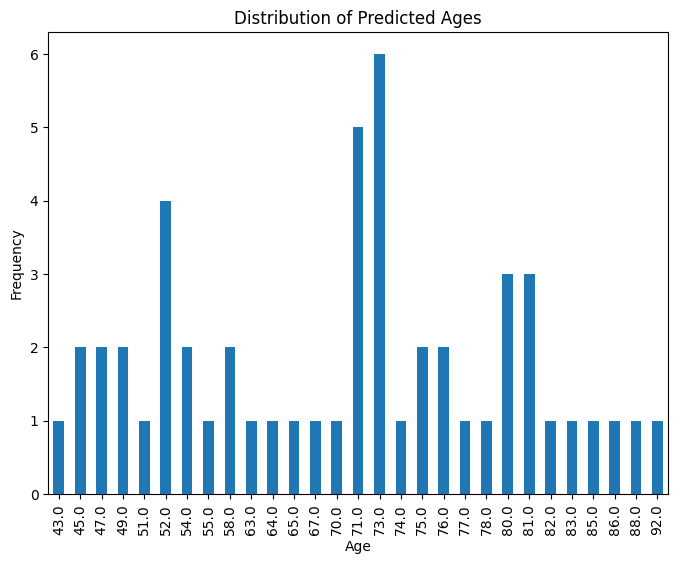

In [39]:
# Aggregating Predictions
y_pred_dtc = dtc.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_rfc = rfc.predict(X_test)

# Combine predictions into a single DataFrame
predictions = pd.DataFrame({
    'dtc': y_pred_dtc,
    'lr': y_pred_lr,
    'rfc': y_pred_rfc
})

# Find the most frequent age for each sample (voting mechanism, taking mode)
predictions['final_pred'] = predictions.mode(axis=1)[0]

# Calculate the most frequent predicted age
most_frequent_age = predictions['final_pred'].mode()[0]

print(f"The most frequent predicted age for developing Alzheimer's is: {most_frequent_age}")

# Visualize the distribution of predicted ages
predictions['final_pred'].value_counts().sort_index().plot(kind='bar', figsize=(8, 6))
plt.title('Distribution of Predicted Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()